## Library import

In [1]:
import time

import numpy as np
from scipy.stats import invwishart
import matplotlib.pyplot as plt

from multivariate_t import multivariate_t
from huber_mean_estimation import huber

# 1D experiments

In [2]:
N=100

def sample_corrupted_pareto(i):
    rng=np.random.RandomState(i)
    N_c = rng.binomial(N,0.05)
    x= np.hstack([rng.pareto(5,size=N-N_c)+1 , 3*np.ones(N_c)]) 
    return x
mean = 5/(5-1)

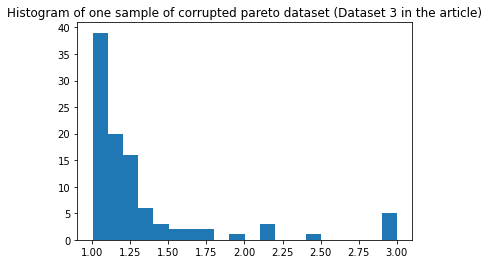

In [3]:
plt.hist(sample_corrupted_pareto(0),bins=20)
plt.title('Histogram of one sample of corrupted pareto dataset (Dataset 3 in the article)')
plt.show()

### The following cell is computationally expensive, run if you have the time.
As an indication, it takes  1min10s on a 16-cores i9 cpu.

In [4]:

M=50
n_jobs = -1 # Use all the cpu
benchmark = huber(beta=0.46)
lepski1 = huber(beta=None,grid=30, t=0.1, n_jobs = n_jobs)
lepski2 = huber(beta=None,grid=30, t=1, n_jobs = n_jobs)
lepski3 = huber(beta=None,grid=30, t=5, n_jobs = n_jobs)

res=[]
init_time=time.time()
for f in range(M):
    X = sample_corrupted_pareto(f)
    
    huber_chap1=lepski1.estimate(X)
    
    huber_chap2=lepski2.estimate(X)
    
    huber_chap3=lepski3.estimate(X) 
    
    res+=[np.abs(np.array([np.median(X),benchmark.estimate(X), huber_chap1,huber_chap2, huber_chap3])-mean)]
print('Computation finished in ', np.round(time.time()-init_time,2),'s')

Computation finished in  70.51 s


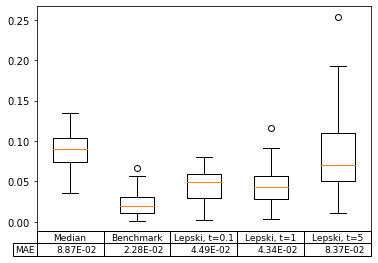

In [5]:
plt.boxplot(np.array(res))

the_table = plt.table(cellText=[['%.2E' % s for s  in np.mean(np.array(res), axis=0)]],
                      rowLabels=['MAE'],
                      colLabels=["Median","Benchmark", "Lepski, t=0.1","Lepski, t=1", "Lepski, t=5"],
                      loc='bottom')
plt.xticks([0], [''])
plt.subplots_adjust(bottom=0.1)
the_table.auto_set_font_size(False)
the_table.set_fontsize(9)

# MultiD experiments

### Plot as dimension increases: illustration of minimax rates

In [6]:
N=50
from tqdm import tqdm
result=[]
Dims = np.arange(50,10560, 500)
for d in tqdm(Dims):
    X = np.random.normal(size=[N,d])
    for f in range(5):
        X[-f]=np.random.normal(size=d)+10
    Ds = np.logspace(-3,3, num=100)
    res = []
    for delta in Ds:
        est = huber(delta, maxiter=100)
        res += [np.linalg.norm(est.estimate(X))]
    result += [np.min(res)]

100%|██████████| 22/22 [05:20<00:00, 14.56s/it]


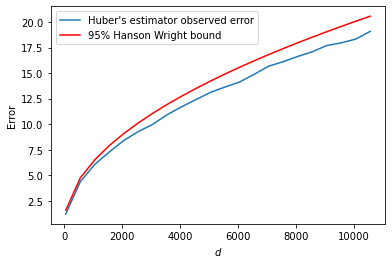

In [7]:
t= np.log(1/0.05)
plt.plot(Dims,result, label="Huber's estimator observed error")
plt.plot(Dims,np.sqrt(2*Dims/N+9*t/N), color="red", label='95% Hanson Wright bound')
plt.xlabel('$d$')
plt.ylabel('Error')
plt.legend()

### Comparison to other estimators on a skewed, corrupted, high dimensional and heavy-tailed dataset.

In [8]:
N=100
d=200
s=invwishart.rvs(d,np.eye(d), random_state=0)
law = multivariate_t(shape=s, df = 3)

In [9]:
print(np.trace(s),np.max(np.linalg.eigvals(s)))

323.717690095815 173.44520581063932


In [10]:
X = law.rvs(size=N)

In [11]:
s2=invwishart.rvs(4*d,np.eye(d))

law2 = multivariate_t(mean = 0.5*np.ones(d),shape=s2, df = 4)
Y = law2.rvs(size=N)
eps = 0.4
melange_eps = np.random.binomial(1,eps,size=N)==1   

In [12]:
# Mixture model
M = np.zeros(X.shape)
M[~melange_eps]=X[~melange_eps]
M[melange_eps]=Y[melange_eps]
# add outliers
for f in range(2):
    M[-f]=np.random.normal(size=d)+5
mean = 0.5*eps*np.ones(d)

In [13]:
print(np.linalg.norm(np.mean(M,axis=0)-mean))
print(np.linalg.norm(np.median(M,axis=0)-mean))

4.923412673138983
3.8491577656841707


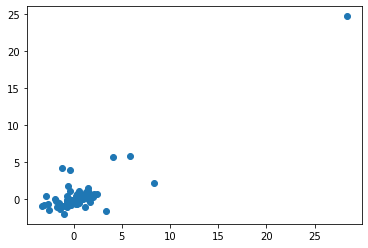

In [14]:
plt.scatter(M[:,0],M[:,1])

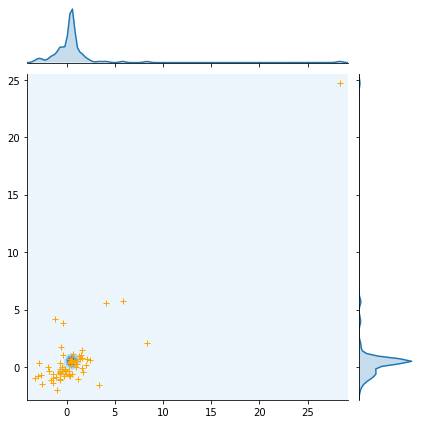

In [15]:
import seaborn as sns
g = sns.jointplot(M[:,0],M[:,1], kind="kde")
g.plot_joint(plt.scatter, c="orange", s=30, linewidth=1, marker="+")

In [16]:
res=[]
Ds = np.logspace(-3,3, num=200)
import time
for delta in Ds:
    #a = time.time()
    est = huber(delta, maxiter=200)
    res += [np.linalg.norm(est.estimate(M)-mean)]
    #print(time.time()-a)

Minimum error obtained  1.669103694871078


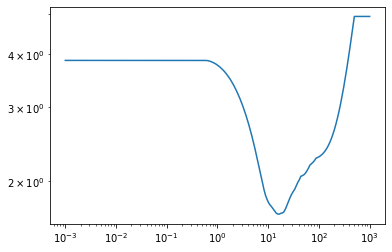

In [17]:
plt.loglog(Ds,res)
print("Minimum error obtained " , np.min(res))

In [18]:
def coordinate_huber(x,delta):
    est = huber(delta, maxiter=100)
    return np.array([est.estimate(xx) for xx in x.T]).T
res=[]
for delta in Ds:
    #a = time.time()
    res += [np.linalg.norm(coordinate_huber(M,delta)-mean)]
    #print(time.time()-a)

Minimum error obtained  1.8999618041075852


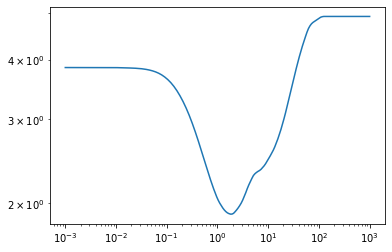

In [19]:
plt.loglog(Ds,res)
print("Minimum error obtained " , np.min(res))